In [1]:
from IPython.display import display, Math, Latex
# This is imported for proper rendering of Latex in Notebook.

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(306)
plt.style.use('seaborn')

# Linear Regression with iterative optimization: `SGDRegressor`

In this notebook, we will build linear regression model with `SGDRegressor`. SGD offers a lot of control over optimization procedure through a number of hyperparameters. However, we need to set them to right values in order to make it work properly for training the model, which makes model selection a very important step.

We use `ShuffleSplit` as cross validation strategy.

In [3]:
from sklearn.model_selection import ShuffleSplit
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split it into training and test.

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)

Divide the data into train and dev (validation) sets.

In [5]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, test_size=0.25, random_state=42)

## Baseline `SGDRegressor`

- **STEP 1:** To begin with, we instantiate a baseline `SGDRegressor` with default parameters.
- **STEP 2:** Train the models with training feature matrix and labels.
- **STEP 3:** Obtain the socre on the training and dev data.

In [7]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

# We instantiate the baseline model with no parameters, to run it on default settings.
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))

print("Mean Absolute Error on Training Set: ", train_mae)
print("Mean Absolute Error on Development Set: ", dev_mae)

Mean Absolute Error on Training Set:  335010457582554.3
Mean Absolute Error on Development Set:  338216494599083.8


We can observe that the MAE is too high. The baseline model doesn't train well. This may happen due to large learning rate or due to the lack of data pre-processing.

Let's investigate this issue by training the model step by step and recording the training loss at each step.

## Adding a feature scaling step

SGD is sensitive to feature scaling. Let's add a feature scaling step and check if we get better MAE.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor(random_state=42)),
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(test_labels, sgd_pipeline.predict(test_features))

print("Mean Absolute Error on Training Set: ", train_mae)
print("Mean Absolute Error on Development Set: ", dev_mae)

Mean Absolute Error on Training Set:  0.7263733471565367
Mean Absolute Error on Development Set:  0.7191122240865042


Although the magnitude of the MAE has reduces, the error is still high.

Let's run the `SGDRegressor` step by step and investigate the issue with training.

## Step-wise training of `SGDRegressor`

- **STEP 1:** Instantiate `SGDRegressor` with `warm_start=True` and `tol=-np.infty` (we allow infinite tolerance).
- **STEP 2:** Train SGD step by step and record regression loss (MSE loss) in each step.
- **STEP 3:** Plot learning curves and see if there is any issues in training.

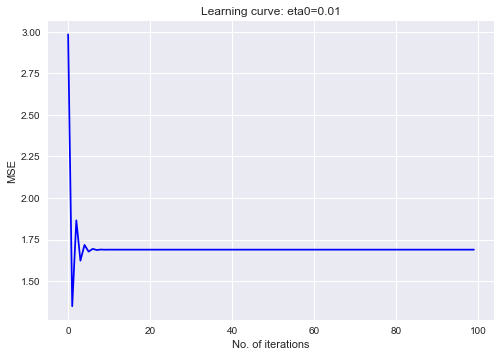

CPU times: user 5.65 s, sys: 1.66 s, total: 7.31 s
Wall time: 1.19 s


In [24]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

eta0 = 1e-2
n_iterations = 100

sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('SGD', SGDRegressor(
        max_iter=1, # To analyse loss after iteration
        tol = -np.infty,
        warm_start=True,
        eta0=eta0,
        random_state=42,
    )),
])

# Now, we run a loop to check the loss after each epoch/iteration
loss = []
for epoch in range(n_iterations):
    sgd_pipeline.fit(train_features, train_labels) 
    # continues where it left off because warm_start=True
    loss.append(mean_squared_error(train_labels,sgd_pipeline.predict(train_features)))

plt.figure()
plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel("No. of iterations")
plt.ylabel("MSE")
plt.title("Learning curve: eta0=" + str(eta0))
plt.show()

The loss is initially reduced and then increased. This could be due to large learning rates. We will reduce the learning rate by a factor of 10 and retry the training.

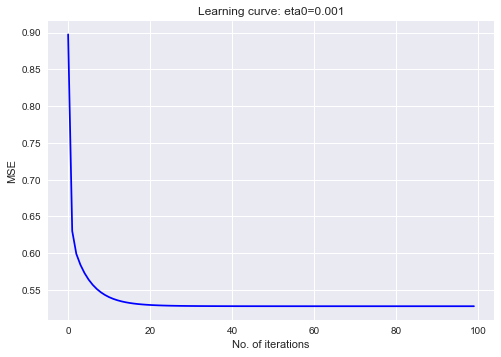

CPU times: user 5.91 s, sys: 1.46 s, total: 7.36 s
Wall time: 1.02 s


In [25]:
%%time

eta0 = 1e-3
n_iterations = 100

sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('SGD', SGDRegressor(
        max_iter=1, # To analyse loss after iteration
        tol = -np.infty,
        warm_start=True,
        eta0=eta0,
        random_state=42,
    )),
])

# Now, we run a loop to check the loss after each epoch/iteration
loss = []
for epoch in range(n_iterations):
    sgd_pipeline.fit(train_features, train_labels) 
    # continues where it left off because warm_start=True
    loss.append(mean_squared_error(train_labels,sgd_pipeline.predict(train_features)))

plt.figure()
plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel("No. of iterations")
plt.ylabel("MSE")
plt.title("Learning curve: eta0=" + str(eta0))
plt.show()

This is an ideal learning curve, where the training loss reduces monotonically as the training progresses.

We can also check the no. of iterations it took for the loss to converge.

In [26]:
print("No. of iterations before reaching convergence criterion: ", sgd_pipeline[-1].n_iter_)
print("No. of weight updates: ", sgd_pipeline[-1].t_)

# #weight_updates = train_features.shape[0] * #iterations

No. of iterations before reaching convergence criterion:  1
No. of weight updates:  11611.0


## Fixing learning rate through validation curves

- **STEP 1:** Provide the list of values to be tried for a hyperparameter.
- **STEP 2:** Instantiate an object of `validation_curve` with estimator, training features and label. Set `scoring` parameter to relevant score.
- **STEP 3:** Convert scores to error.
- **STEP 4:** Plot validation curve with the value of hyper-parameter on *x*-axis and error on the *y*-axis.
- **STEP 5:** Fix the hyper-parameter value where test error is the least.

**NOTE:** THESE STEPS CAN BE FOLLOWED FOR TUNING ANY HYPER-PARAMETER OF A MODEL. (not just the learning rate)

In [27]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve

eta0 = [1e-5, 1e-4, 1e-3, 1e-2]

train_scores, test_scores = validation_curve(
    sgd_pipeline,
    com_train_features,
    com_train_labels,
    param_name="SGD__eta0", # We are testing for the parameter eta0
    param_range=eta0,
    cv=shuffle_split_cv,
    scoring='neg_mean_squared_error',
    n_jobs=2,
)

train_errors, test_errors = -train_scores, -test_scores

CPU times: user 116 ms, sys: 69 ms, total: 185 ms
Wall time: 2.59 s


In [29]:
train_errors
#  each row corresponds to the error across 10 folds for a fixed eta0

array([[5.4970157 , 5.47418537, 5.45561725, 5.45897979, 5.47585689,
        5.49191576, 5.50467408, 5.46853424, 5.45976827, 5.47144762],
       [4.30425385, 4.28546385, 4.26459393, 4.27506337, 4.28259875,
        4.29616127, 4.31118851, 4.27922324, 4.27646987, 4.2809932 ],
       [0.85589893, 0.85018122, 0.83657382, 0.84864292, 0.83959774,
        0.84994956, 0.85071409, 0.84445808, 0.85800914, 0.84362491],
       [0.66889017, 5.28976551, 0.83655736, 0.94020426, 1.54525895,
        0.99049287, 0.55470573, 0.85670068, 7.67925582, 0.95559332]])

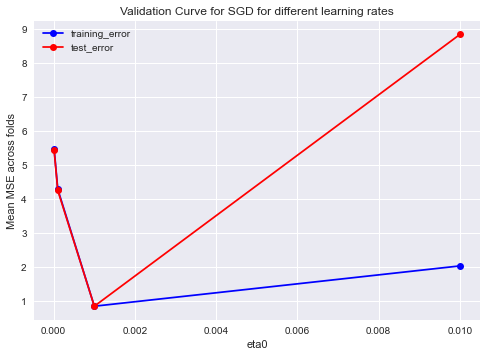

In [34]:
plt.figure()
plt.plot(eta0, train_errors.mean(axis=1), 'b-o', label="training_error")
plt.plot(eta0, test_errors.mean(axis=1), 'r-o', label="test_error")
plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean MSE across folds")
plt.title("Validation Curve for SGD for different learning rates")
plt.show()

As we can see here, for `eta0 = 1e-3`, the test error is the least and hence we fix that value as the value for `eta0`.

Next, we also plot the standard deviation of errors.

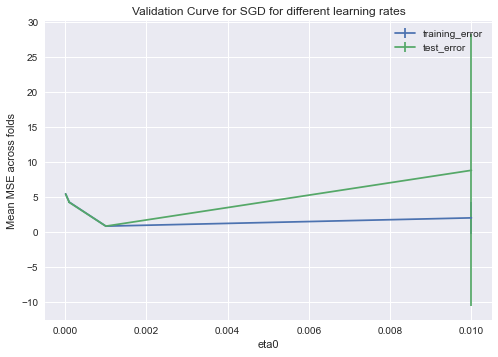

In [35]:
plt.figure()
plt.errorbar(eta0, train_errors.mean(axis=1), yerr=train_errors.std(axis=1), label="training_error")
plt.errorbar(eta0, test_errors.mean(axis=1), yerr=test_errors.std(axis=1), label="test_error")
plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean MSE across folds")
plt.title("Validation Curve for SGD for different learning rates")
plt.show()

## Final `SGDRegressor`

In [40]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

# Default learning strategy
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('SGD', SGDRegressor(
        max_iter=500,
        early_stopping=True,
        eta0=1e-3,
        tol=1e-3,
        validation_fraction=0.2,
        n_iter_no_change=5,
        average=10,
        random_state=42,
    )),
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean absolute error on Training set: ", train_mae)
print("Mean absolute error on Development set: ", dev_mae)

Mean absolute error on Training set:  0.579376454514559
Mean absolute error on Development set:  0.5689180241137523
CPU times: user 97.2 ms, sys: 35.9 ms, total: 133 ms
Wall time: 35.8 ms


In [39]:
print("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print("Number of weight updates: ", sgd_pipeline[-1].t_)

Number of SGD iterations:  7
Number of weight updates:  81271.0


In [41]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

# Constant learning strategy
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('SGD', SGDRegressor(
        max_iter=500,
        early_stopping=True,
        eta0=1e-3,
        tol=1e-3,
        learning_rate='constant',
        validation_fraction=0.2,
        n_iter_no_change=5,
        average=10,
        random_state=42,
    )),
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean absolute error on Training set: ", train_mae)
print("Mean absolute error on Development set: ", dev_mae)

print("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print("Number of weight updates: ", sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5359339681114987
Mean absolute error on Development set:  0.5151099728924144
Number of SGD iterations:  8
Number of weight updates:  92881.0
CPU times: user 75.3 ms, sys: 25 ms, total: 100 ms
Wall time: 22.8 ms


In [42]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

# Adaptive learning strategy
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('SGD', SGDRegressor(
        max_iter=500,
        early_stopping=True,
        eta0=1e-3,
        tol=1e-3,
        learning_rate='adaptive',
        validation_fraction=0.2,
        n_iter_no_change=5,
        average=10,
        random_state=42,
    )),
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean absolute error on Training set: ", train_mae)
print("Mean absolute error on Development set: ", dev_mae)

print("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print("Number of weight updates: ", sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5340193046836148
Mean absolute error on Development set:  0.5198356196858102
Number of SGD iterations:  33
Number of weight updates:  383131.0
CPU times: user 233 ms, sys: 73.5 ms, total: 306 ms
Wall time: 56 ms


## Setting `max_iters`

Ideally `SGDRegressor` requires around `1e6` weight updates to converge rpoperly. So, we can cap the maximum no. of iterations.

In [43]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [44]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error

# constant learning rate - because of best accuracy
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('SGD', SGDRegressor(
        max_iter=max_iter,
        early_stopping=True,
        eta0=1e-3,
        tol=1e-3,
        learning_rate='constant',
        validation_fraction=0.2,
        n_iter_no_change=5,
        average=10,
        random_state=42,
    )),
])

sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print("Mean absolute error on Training set: ", train_mae)
print("Mean absolute error on Development set: ", dev_mae)

print("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print("Number of weight updates: ", sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5359339681114987
Mean absolute error on Development set:  0.5151099728924144
Number of SGD iterations:  8
Number of weight updates:  92881.0
CPU times: user 30.8 ms, sys: 61.5 ms, total: 92.3 ms
Wall time: 26.1 ms


## Summary

In this notebook, we saw:
- how to build `SGDRegressor` model.
- how to tune the learning rate.
- how to use different `learning_rate` and their impact on convergence.
- how to use early stopping and averaged SGD.
- how to tune hyperparameters with validation curves.